In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp
import random
import gillespie 
from scipy.interpolate import interp1d

In [3]:
# modélise l'ODE 

In [4]:
mu=0.1
c=5*(10)**(-3)
K=1000
n0=2
T=5
stochastic_realisations=5

In [5]:
def systeme(t,X,c,K):
    n=X[0]
    dn_dt=c*(K-n)*n
    return dn_dt
    

In [6]:
solution=solve_ivp(systeme,[0,T],[n0],method='RK45',args=(c,K))
print(solution.y[0])

[  2.           2.60007893   7.14146008  24.8074512   91.40848472
 307.94031702 709.53519111 914.2704768  979.03036168 995.09417988
 999.12519433 999.81747967 999.83200608 999.15920275 999.83827143]


In [7]:
solution.t

array([0.        , 0.05259921, 0.25558248, 0.50821563, 0.78317613,
       1.08029144, 1.42073056, 1.71534843, 2.0099663 , 2.30624833,
       2.67633068, 3.15302997, 3.8044387 , 4.65445447, 5.        ])

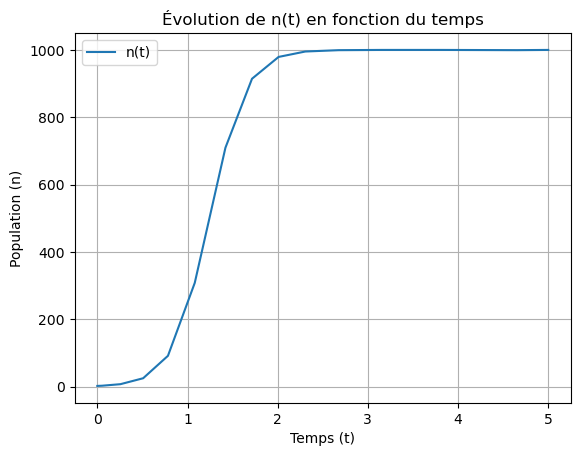

In [8]:
t=solution.t
n=solution.y[0]

plt.plot(t,n,label='n(t)')
plt.xlabel('Temps (t)')
plt.ylabel('Population (n)')
plt.title('Évolution de n(t) en fonction du temps')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#maintenant résolution stochastique 

In [10]:
T=5
initials=[n0]
propensities=[lambda n :mu*n, #death
             lambda n: (mu +c*(K-n))*n, #birth
             ]
stoichiometry = [
        [-1],  # Wildtype death
        [ 1],  # Wildtype birth
          ]
t, pop=gillespie.simulate(initials, propensities, stoichiometry,T)
n_values=[count[0] for count in pop]



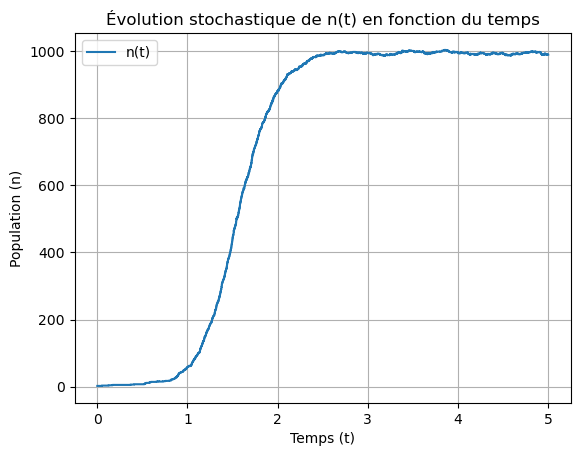

In [11]:
# Tracé des résultats
plt.step(t, n_values, where='post', label='n(t)')
plt.xlabel('Temps (t)')
plt.ylabel('Population (n)')
plt.title('Évolution stochastique de n(t) en fonction du temps')
plt.legend()
plt.grid(True)
plt.show()

Explications du Code

Simulation multiple : Nous effectuons 5 réalisations stochastiques du modèle avec simulate.

Interpolation : Nous interpolons les résultats de chaque réalisation pour obtenir des valeurs de population alignées sur des points de temps communs.

Calcul de la moyenne et de l'erreur standard : Nous calculons la moyenne d'ensemble et l'erreur standard pour chaque point de temps.

Tracé : Nous traçons la moyenne avec des barres d'erreur représentant l'erreur standard de la moyenne.

In [12]:
matrice=np.array([[-1,1]])
mu=0.1
c=5*(10)**(-3)
K=1000
n0=2
T=5
stochastic_realisations=5

In [13]:
matrice[:]

array([[-1,  1]])

In [14]:
all_times=[]
all_populations=[]
for _ in range (stochastic_realisations):
    
    t=0
    N=n0
    times_sim=[t]
    pop_sim=[N]
    
    while t<T:
        a0=mu*N
        a1=(mu+ c*(K-N))*N
        somme=a1+a0
        if somme==0:
            break
        r1=np.random.rand()
        if (r1<a0/somme):
            N-=1
        else:
            N+=1
        r2=np.random.rand()
        tau = np.log(1/r2)/somme
    # Mettre à jour les populations et le temps
    #print(t)
        t = t + tau
        if t>=T:
            print("on a depasse la limite")
            break
        times_sim.append(t)
        pop_sim.append(N)

    all_populations.append(pop_sim)
    all_times.append(times_sim)

all_times = [np.array(sim_times) for sim_times in all_times]
all_populations = [np.array(sim_pop) for sim_pop in all_populations]


on a depasse la limite
on a depasse la limite
on a depasse la limite
on a depasse la limite
on a depasse la limite


In [15]:
# Interpolation des résultats pour aligner les points de temps
common_times = np.linspace(0, T, 500)
all_interpolated_counts = []

for time, counts in zip(all_times, all_populations):
    interpolated_counts = interp1d(time, counts, kind='previous', fill_value="extrapolate")(common_times)
    all_interpolated_counts.append(interpolated_counts)

all_interpolated_counts = np.array(all_interpolated_counts)


In [16]:
# Calcul de la moyenne et de l'erreur standard
mean_counts = np.mean(all_interpolated_counts, axis=0)
stderr_counts = np.std(all_interpolated_counts, axis=0) / np.sqrt(stochastic_realisations)


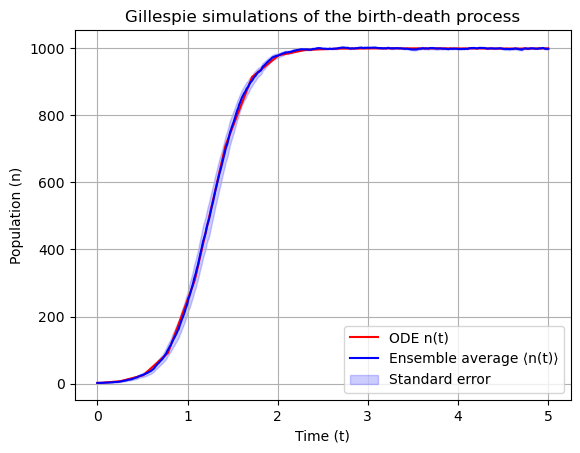

In [17]:
#tracé avec la courbe déterministe 
# Courbe déterministe
t_det = solution.t
n_det = solution.y[0]
plt.plot(t_det, n_det, 'r-', label='ODE n(t)')
# Tracé des résultats

plt.plot(common_times, mean_counts, 'b-', label='Ensemble average ⟨n(t)⟩')
plt.fill_between(common_times, mean_counts - stderr_counts, mean_counts + stderr_counts, color='blue', alpha=0.2, label='Standard error')

plt.xlabel('Time (t)')
plt.ylabel('Population (n)')
plt.title('Gillespie simulations of the birth-death process')
plt.legend()
plt.grid(True)
plt.show()